In [4]:
import numpy as np 

import line_profiler
import atexit
from numba import njit

In [2]:
profile = line_profiler.LineProfiler()
atexit.register(profile.print_stats)

import time

In [5]:
from scipy.interpolate.interpnd import _ndim_coords_from_arrays
import itertools
class RegularGridInterpolatorOG:
   
    # this class is based on code originally programmed by Johannes Buchner,
    # see https://github.com/JohannesBuchner/regulargrid
    
    def __init__(self, points, values, method="linear", bounds_error=True,
                 fill_value=np.nan):
        if method not in ["linear", "nearest", "numba"]:
            raise ValueError("Method '%s' is not defined" % method)
        self.method = method
        self.bounds_error = bounds_error

        if not hasattr(values, 'ndim'):
            # allow reasonable duck-typed values
            values = np.asarray(values)

        if len(points) > values.ndim:
            raise ValueError("There are %d point arrays, but values has %d "
                             "dimensions" % (len(points), values.ndim))

        if hasattr(values, 'dtype') and hasattr(values, 'astype'):
            if not np.issubdtype(values.dtype, np.inexact):
                values = values.astype(float)

        self.fill_value = fill_value
        if fill_value is not None:
            fill_value_dtype = np.asarray(fill_value).dtype
            if (hasattr(values, 'dtype') and not
                    np.can_cast(fill_value_dtype, values.dtype,
                                casting='same_kind')):
                raise ValueError("fill_value must be either 'None' or "
                                 "of a type compatible with values")

        for i, p in enumerate(points):
            if not np.all(np.diff(p) > 0.):
                raise ValueError("The points in dimension %d must be strictly "
                                 "ascending" % i)
            if not np.asarray(p).ndim == 1:
                raise ValueError("The points in dimension %d must be "
                                 "1-dimensional" % i)
            if not values.shape[i] == len(p):
                raise ValueError("There are %d points and %d values in "
                                 "dimension %d" % (len(p), values.shape[i], i))
        self.grid = tuple([np.asarray(p) for p in points])
        self.values = values

    def __call__(self, xi, method=None):
        """
        Interpolation at coordinates
        Parameters
        ----------
        xi : ndarray of shape (..., ndim)
            The coordinates to sample the gridded data at
        method : str
            The method of interpolation to perform. Supported are "linear" and
            "nearest".
        """
        method = self.method if method is None else method
        if method not in ["linear", "nearest", "numba"]:
            raise ValueError("Method '%s' is not defined" % method)

        ndim = len(self.grid)
        xi = _ndim_coords_from_arrays(xi, ndim=ndim)
        if xi.shape[-1] != len(self.grid):
            raise ValueError("The requested sample points xi have dimension "
                             "%d, but this RegularGridInterpolator has "
                             "dimension %d" % (xi.shape[1], ndim))

        xi_shape = xi.shape
        xi = xi.reshape(-1, xi_shape[-1])

        if self.bounds_error:
            for i, p in enumerate(xi.T):
                if not np.logical_and(np.all(self.grid[i][0] <= p),
                                      np.all(p <= self.grid[i][-1])):
                    raise ValueError("One of the requested xi is out of bounds "
                                     "in dimension %d" % i)
                    
#         print(xi.T)
#         t_1 = time.time()
        indices, norm_distances, out_of_bounds = self._find_indices(xi.T)
#         t_2 = time.time()
#         print(t_2 - t_1, 's')
        if method == "linear":
            result = self._evaluate_linear(indices,
                                           norm_distances,
                                           out_of_bounds)
        elif method == "nearest":
            result = self._evaluate_nearest(indices,
                                            norm_distances,
                                            out_of_bounds)
        elif method == 'numba':
            values = self.values
            edges = list(itertools.product(*[[i, i + 1] for i in indices]))
            result = evaluate_linear_nb(values, 
                                        edges,
                                        indices,
                                        norm_distances,
                                        out_of_bounds)
            
        if not self.bounds_error and self.fill_value is not None:
            result[out_of_bounds] = self.fill_value

        return result.reshape(xi_shape[:-1] + self.values.shape[ndim:])

    def _evaluate_linear(self, indices, norm_distances, out_of_bounds):
        # slice for broadcasting over trailing dimensions in self.values
        vslice = (slice(None),) + (None,)*(self.values.ndim - len(indices))
#         print(vslice)
        # find relevant values
        # each i and i+1 represents a edge
        edges = itertools.product(*[[i, i + 1] for i in indices])
#         print(indices)
#         print(*list(edges), sep='\n')
  
        values = 0.
        for edge_indices in edges:
#             print(a,*edge_indices, sep='\n')

#             weight=np.product([np.where(ei == i, 1 - yi, yi) for ei, i, yi in zip(edge_indices, indices, norm_distances)], axis=0)
            weight = 1.
            for ei, i, yi in zip(edge_indices, indices, norm_distances):
                weight *= np.where(ei == i, 1 - yi, yi)
#             print(weight)
#             print(np.product([np.where(ei == i, 1 - yi, yi) for ei, i, yi in zip(edge_indices, indices, norm_distances)], axis=0))
#             print(weight)
#             print(edge_indices)
#             print(self.values[edge_indices])
            values += self.values[edge_indices] * weight[vslice]
        return values

    def _evaluate_nearest(self, indices, norm_distances, out_of_bounds):
        idx_res = [np.where(yi <= .5, i, i + 1)
                   for i, yi in zip(indices, norm_distances)]
        return self.values[tuple(idx_res)]

    def __find_indices(self, xi):
        # find relevant edges between which xi are situated
        indices = []
        # compute distance to lower edge in unity units
        norm_distances = []
        # check for out of bounds xi
        out_of_bounds = np.zeros((xi.shape[1]), dtype=bool)
        # iterate through dimensions
#         print(list(map(np.shape, self.grid)))
        grid_new = list(map(lambda x: x.reshape(-1,1), self.grid))
        for x, grid in zip(xi, grid_new):
#             i = np.searchsorted(grid, x) - 1
            i = np.sum(grid < x, axis=0)-1
            i[i < 0] = 0
            i[i > grid.size - 2] = grid.size - 2
#             print(i, np.sum(grid.reshape(-1,1) < x, axis=0)-1)

            indices.append(i)
            norm_distances.append((x - grid.ravel()[i]) /
                                  (grid.ravel()[i + 1] - grid.ravel()[i]))
            if not self.bounds_error:
                out_of_bounds += x < grid[0]
                out_of_bounds += x > grid[-1]
#         print(indices)
#         print(norm_distances)
        return indices, norm_distances, out_of_bounds
    
    def _find_indices(self, xi):
        # find relevant edges between which xi are situated
        indices = []
        # compute distance to lower edge in unity units
        norm_distances = []
        # check for out of bounds xi
        out_of_bounds = np.zeros((xi.shape[1]), dtype=bool)
        # iterate through dimensions
        for x, grid in zip(xi, self.grid):
            i = np.searchsorted(grid, x) - 1
            i[i < 0] = 0
            i[i > grid.size - 2] = grid.size - 2
            indices.append(i)
            norm_distances.append((x - grid[i]) /
                                  (grid[i + 1] - grid[i]))
            if not self.bounds_error:
                out_of_bounds += x < grid[0]
                out_of_bounds += x > grid[-1]
#         print(indices)
#         print(norm_distances)
        return indices, norm_distances, out_of_bounds
    
# @njit 
# def evaluate_linear_nb(values, edges, indices, norm_distances, out_of_bounds):
#         # slice for broadcasting over trailing dimensions in self.values
# #         vslice = (slice(None),) + (None,)*(values.ndim - len(indices))
#         # find relevant values
#         # each i and i+1 represents a edge
        
# #         print(list(edges))
  
#         values = 0.
#         for edge_indices in edges:
# #             print(edge_indices)
#             weight = 1.
#             for ei, i, yi in zip(edge_indices, indices, norm_distances):
#                 weight *= np.where(ei == i, 1 - yi, yi)
#             values += np.asarray(values[edge_indices]) * weight[:, None, None]
#         return values

In [6]:
def f(x, y, z):
    return 2 * x**3 + 3 * y**2 - z

In [7]:
n = 10
x = np.linspace(1, 4, n+10)
y = np.linspace(4, 7, n)
z = np.linspace(7, 9, n)
xg, yg ,zg = np.meshgrid(x, y, z, indexing='ij', sparse=True)
data = f(xg, yg, zg)

my_interpolating_function = RegularGridInterpolatorOG((x, y, z), data)

pts = np.array([[2.1, 6.2, 8.3], 
                [3.3, 5.2, 7.1]])

# pts = np.array([[2.1, 6.2, 8.3], 
#                 [3.3, 5.2, 7.1],
#                 [2.1, 6.2, 8.3], 
#                 [3.3, 5.2, 7.1],
#                 [2.1, 6.2, 8.3], 
#                 [3.3, 5.2, 7.1],
#                 [2.1, 6.2, 8.3], 
#                 [3.3, 5.2, 7.1],
#                 [2.1, 6.2, 8.3], 
#                 [3.3, 5.2, 7.1],
#                 [2.1, 6.2, 8.3], 
#                 [3.3, 5.2, 7.1],
#                 [2.1, 6.2, 8.3], 
#                 [3.3, 5.2, 7.1],
#                 [2.1, 6.2, 8.3], 
#                 [3.3, 5.2, 7.1],
#                 [2.1, 6.2, 8.3], 
#                 [3.3, 5.2, 7.1],
#                 [2.1, 6.2, 8.3], 
#                 [3.3, 5.2, 7.1],
#                 [2.1, 6.2, 8.3], 
#                 [3.3, 5.2, 7.1],
#                 [2.1, 6.2, 8.3], 
#                 [3.3, 5.2, 7.1],
#                 [2.1, 6.2, 8.3], 
#                 [3.3, 5.2, 7.1],
#                 [2.1, 6.2, 8.3], 
#                 [3.3, 5.2, 7.1],
#                 [2.1, 6.2, 8.3], 
#                 [3.3, 5.2, 7.1]])

grid = np.asarray([x,y,z])

my_interpolating_function(pts)

C:\Users\tbain\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


array([125.63188511, 146.09495553])

In [8]:
y_true = f(*pts.T)
y_predict = my_interpolating_function(pts)

print(y_true)
print(y_predict)

[125.542 145.894]
[125.63188511 146.09495553]


In [36]:
np.abs(y_true - y_predict)

array([0.08988511, 0.20095553])

In [28]:
y_predict = 10**my_interpolating_function_log(np.log10(pts))

print(y_true)
print(y_predict)

[125.542 145.894]
[125.93588015 146.12118687]


In [29]:
np.abs(y_true - y_predict) / y_true

array([0.00313744, 0.00155721])

In [25]:
my_interpolating_function_log = RegularGridInterpolatorOG((np.log10(x), np.log10(y), np.log10(z)), np.log10(data))

In [217]:
10**my_interpolating_function_log(np.log10(pts))

array([125.54203151, 145.89401799])

<ipython-input-31-9887dea5415b>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x, y, np.log10(data[:,:,0]))


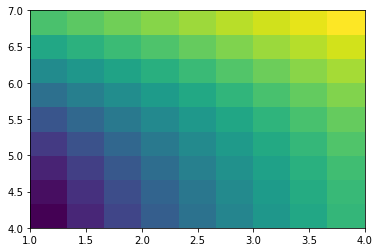

In [31]:
import matplotlib.pyplot as plt
plt.pcolormesh(x, y, np.log10(data[:,:,0]))

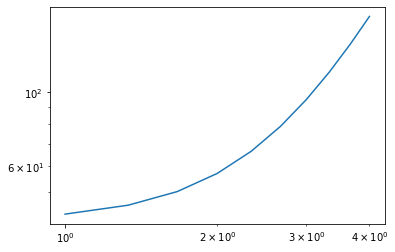

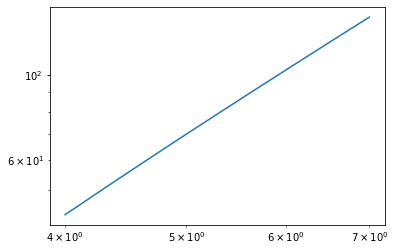

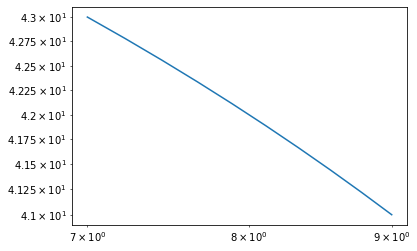

In [32]:
plt.plot(x, data[:,0,0])
plt.xscale('log')
plt.yscale('log')
plt.show()

plt.plot(y, data[0,:,0])
plt.xscale('log')
plt.yscale('log')
plt.show()

plt.plot(z, data[0,0,:])
plt.xscale('log')
plt.yscale('log')
plt.show()

In [182]:
%timeit 10**my_interpolating_function_log(np.log10(pts))

175 µs ± 2.41 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [176]:
%timeit my_interpolating_function(pts)

176 µs ± 2.09 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [143]:
%timeit my_interpolating_function(pts)

250 µs ± 1.33 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [70]:
indices = np.sum(grid.T < pts.reshape(len(pts),1,3), axis=1) - 1 

In [71]:
indices.T

array([[3, 7],
       [7, 3],
       [6, 0]])

In [72]:
norm_distances = ((pts - grid[np.arange(3), indices]) / (grid[np.arange(3), indices+1] - grid[np.arange(3), indices]))
norm_distances

array([[0.66666667, 0.33333333, 0.5       ],
       [0.66666667, 1.        , 0.5       ]])

In [121]:
np.hstack([indices.T, indices.T + 1]).T.reshape(len(pts),2,2).T

ValueError: cannot reshape array of size 180 into shape (30,2,2)

In [122]:
180/4

45.0

In [123]:
indices.shape

(30, 3)

In [89]:
np.array([[i, i + 1] for i in indices.T])

array([[[3, 7],
        [4, 8]],

       [[7, 3],
        [8, 4]],

       [[6, 0],
        [7, 1]]])

In [ ]:
np.transpose(np.meshgrid(*[[i, i + 1] for i in indices.T], indexing='ij'), (1,2,0)).reshape(-1,2)

In [95]:
it = itertools.product(*[[i, i + 1] for i in indices.T])
np.fromiter(itertools.chain(it), int)

ValueError: setting an array element with a sequence.

In [91]:

def cartesian_product_mixed_type(*arrays):
    arrays = *map(np.asanyarray, arrays),
    dtype = np.dtype([(f'f{i}', a.dtype) for i, a in enumerate(arrays)])
    out = np.empty((*map(len, arrays),), dtype)
    idx = slice(None), *itertools.repeat(None, len(arrays) - 1)
    for i, a in enumerate(arrays):
        out[f'f{i}'] = a[idx[:len(arrays) - i]]
    return out.ravel()

In [92]:
np.array(some_list)[np.rollaxis(np.indices((len(some_list),) * some_length), 0, some_length + 1).reshape(-1, some_length)]

ValueError: could not broadcast input array from shape (2,1,1,2) into shape (2,2,2)

In [90]:
edge_indices = np.array(list(itertools.product(*[[i, i + 1] for i in indices.T])))
# edge_indices = np.array(list(itertools.product(indices.T, indices.T+1)))
edge_indices, edge_indices.shape

(array([[[3, 7],
         [7, 3],
         [6, 0]],
 
        [[3, 7],
         [7, 3],
         [7, 1]],
 
        [[3, 7],
         [8, 4],
         [6, 0]],
 
        [[3, 7],
         [8, 4],
         [7, 1]],
 
        [[4, 8],
         [7, 3],
         [6, 0]],
 
        [[4, 8],
         [7, 3],
         [7, 1]],
 
        [[4, 8],
         [8, 4],
         [6, 0]],
 
        [[4, 8],
         [8, 4],
         [7, 1]]]),
 (8, 3, 2))

In [126]:
np.asarray(list(itertools.product(*[[i, i + 1] for i in indices.T])))

array([[[3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3,
         7, 3, 7, 3, 7, 3, 7, 3, 7],
        [7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7,
         3, 7, 3, 7, 3, 7, 3, 7, 3],
        [6, 0, 6, 0, 6, 0, 6, 0, 6, 0, 6, 0, 6, 0, 6, 0, 6, 0, 6, 0, 6,
         0, 6, 0, 6, 0, 6, 0, 6, 0]],

       [[3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3,
         7, 3, 7, 3, 7, 3, 7, 3, 7],
        [7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7,
         3, 7, 3, 7, 3, 7, 3, 7, 3],
        [7, 1, 7, 1, 7, 1, 7, 1, 7, 1, 7, 1, 7, 1, 7, 1, 7, 1, 7, 1, 7,
         1, 7, 1, 7, 1, 7, 1, 7, 1]],

       [[3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3,
         7, 3, 7, 3, 7, 3, 7, 3, 7],
        [8, 4, 8, 4, 8, 4, 8, 4, 8, 4, 8, 4, 8, 4, 8, 4, 8, 4, 8, 4, 8,
         4, 8, 4, 8, 4, 8, 4, 8, 4],
        [6, 0, 6, 0, 6, 0, 6, 0, 6, 0, 6, 0, 6, 0, 6, 0, 6, 0, 6, 0, 6,
         0, 6, 0, 6, 0, 6, 0, 6, 0]],

       [[3, 7

In [127]:
%timeit np.array(list(itertools.product(*[[i, i + 1] for i in indices.T])))

KeyboardInterrupt: 

In [128]:
data[[3,7], [7,3], [6,0]]

array([117.148, 124.612])

In [129]:
edge_indices.transpose(1,0,2).shape

(3, 8, 30)

In [130]:
data[tuple(edge_indices.transpose(1,0,2))]

array([[117.148, 124.612, 117.148, 124.612, 117.148, 124.612, 117.148,
        124.612, 117.148, 124.612, 117.148, 124.612, 117.148, 124.612,
        117.148, 124.612, 117.148, 124.612, 117.148, 124.612, 117.148,
        124.612, 117.148, 124.612, 117.148, 124.612, 117.148, 124.612,
        117.148, 124.612],
       [116.948, 124.412, 116.948, 124.412, 116.948, 124.412, 116.948,
        124.412, 116.948, 124.412, 116.948, 124.412, 116.948, 124.412,
        116.948, 124.412, 116.948, 124.412, 116.948, 124.412, 116.948,
        124.412, 116.948, 124.412, 116.948, 124.412, 116.948, 124.412,
        116.948, 124.412],
       [128.398, 133.702, 128.398, 133.702, 128.398, 133.702, 128.398,
        133.702, 128.398, 133.702, 128.398, 133.702, 128.398, 133.702,
        128.398, 133.702, 128.398, 133.702, 128.398, 133.702, 128.398,
        133.702, 128.398, 133.702, 128.398, 133.702, 128.398, 133.702,
        128.398, 133.702],
       [128.198, 133.502, 128.198, 133.502, 128.198, 133.502, 128.1

In [131]:
weights

array([[0.11111111, 0.        ],
       [0.11111111, 0.        ],
       [0.05555556, 0.16666667],
       [0.05555556, 0.16666667],
       [0.22222222, 0.        ],
       [0.22222222, 0.        ],
       [0.11111111, 0.33333333],
       [0.11111111, 0.33333333]])

In [134]:

%timeit np.sum(data[tuple(map(tuple, edge_indices.transpose(1,0,2)))] * weights, axis=0)

24.9 µs ± 320 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [135]:
%timeit np.diag(np.dot(data[tuple(map(tuple, edge_indices.transpose(1,0,2)))].T, weights))

24.6 µs ± 873 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [95]:
data[tuple(map(tuple, edge_indices.transpose(1,0,2)))].shape, weights.shape

((8, 2), (8, 2))

In [133]:
np.sum(data[edge_indices[:,0], edge_indices[:,1], edge_indices[:,2]] * weights, axis=0)

array([125.85 , 146.286, 125.85 , 146.286, 125.85 , 146.286, 125.85 ,
       146.286, 125.85 , 146.286, 125.85 , 146.286, 125.85 , 146.286,
       125.85 , 146.286, 125.85 , 146.286, 125.85 , 146.286, 125.85 ,
       146.286, 125.85 , 146.286, 125.85 , 146.286, 125.85 , 146.286,
       125.85 , 146.286])

In [103]:
indices.shape, edge_indices.T.shape

((2, 3), (2, 3, 8))

In [114]:
1-norm_distances, norm_distances

(array([[0.33333333, 0.66666667, 0.5       ],
        [0.33333333, 0.        , 0.5       ]]),
 array([[0.66666667, 0.33333333, 0.5       ],
        [0.66666667, 1.        , 0.5       ]]))

In [132]:
weights = np.product(np.where(edge_indices == indices.T, 1-norm_distances.T, norm_distances.T).T, axis=1).T
weights

array([[0.11111111, 0.        , 0.11111111, 0.        , 0.11111111,
        0.        , 0.11111111, 0.        , 0.11111111, 0.        ,
        0.11111111, 0.        , 0.11111111, 0.        , 0.11111111,
        0.        , 0.11111111, 0.        , 0.11111111, 0.        ,
        0.11111111, 0.        , 0.11111111, 0.        , 0.11111111,
        0.        , 0.11111111, 0.        , 0.11111111, 0.        ],
       [0.11111111, 0.        , 0.11111111, 0.        , 0.11111111,
        0.        , 0.11111111, 0.        , 0.11111111, 0.        ,
        0.11111111, 0.        , 0.11111111, 0.        , 0.11111111,
        0.        , 0.11111111, 0.        , 0.11111111, 0.        ,
        0.11111111, 0.        , 0.11111111, 0.        , 0.11111111,
        0.        , 0.11111111, 0.        , 0.11111111, 0.        ],
       [0.05555556, 0.16666667, 0.05555556, 0.16666667, 0.05555556,
        0.16666667, 0.05555556, 0.16666667, 0.05555556, 0.16666667,
        0.05555556, 0.16666667, 0.05555556, 0.

In [150]:
data.shape

(11, 11, 11)

In [151]:
edge_indices.shape

(8, 3, 2)

In [182]:
data[edge_indices].shape

(8, 3, 2, 11, 11)

In [ ]:
values = 0.
for a, edge_indices in enumerate(edges):
    print(a,*edge_indices, sep='\n')
    weight = 1.
    for ei, i, yi in zip(edge_indices, indices, norm_distances):
        weight *= np.where(ei == i, 1 - yi, yi)
    values += np.asarray(self.values[edge_indices]) * weight[vslice]
return values

In [9]:
from scipy.interpolate.interpnd import _ndim_coords_from_arrays
import itertools
class RegularGridInterpolator:
   
    # this class is based on code originally programmed by Johannes Buchner,
    # see https://github.com/JohannesBuchner/regulargrid
    
    def __init__(self, points, values, method="linear", bounds_error=True,
                 fill_value=np.nan):
        if method not in ["linear", "nearest", "numba"]:
            raise ValueError("Method '%s' is not defined" % method)
        self.method = method
        self.bounds_error = bounds_error

        if not hasattr(values, 'ndim'):
            # allow reasonable duck-typed values
            values = np.asarray(values)

        if len(points) > values.ndim:
            raise ValueError("There are %d point arrays, but values has %d "
                             "dimensions" % (len(points), values.ndim))

        if hasattr(values, 'dtype') and hasattr(values, 'astype'):
            if not np.issubdtype(values.dtype, np.inexact):
                values = values.astype(float)

        self.fill_value = fill_value
        if fill_value is not None:
            fill_value_dtype = np.asarray(fill_value).dtype
            if (hasattr(values, 'dtype') and not
                    np.can_cast(fill_value_dtype, values.dtype,
                                casting='same_kind')):
                raise ValueError("fill_value must be either 'None' or "
                                 "of a type compatible with values")

        for i, p in enumerate(points):
            if not np.all(np.diff(p) > 0.):
                raise ValueError("The points in dimension %d must be strictly "
                                 "ascending" % i)
            if not np.asarray(p).ndim == 1:
                raise ValueError("The points in dimension %d must be "
                                 "1-dimensional" % i)
            if not values.shape[i] == len(p):
                raise ValueError("There are %d points and %d values in "
                                 "dimension %d" % (len(p), values.shape[i], i))
        self.grid = tuple([np.asarray(p) for p in points])
        self.values = values

    def __call__(self, xi, method=None):
        """
        Interpolation at coordinates
        Parameters
        ----------
        xi : ndarray of shape (..., ndim)
            The coordinates to sample the gridded data at
        method : str
            The method of interpolation to perform. Supported are "linear" and
            "nearest".
        """
        method = self.method if method is None else method
        if method not in ["linear", "nearest", "numba"]:
            raise ValueError("Method '%s' is not defined" % method)

        ndim = len(self.grid)
        xi = _ndim_coords_from_arrays(xi, ndim=ndim)
        if xi.shape[-1] != len(self.grid):
            raise ValueError("The requested sample points xi have dimension "
                             "%d, but this RegularGridInterpolator has "
                             "dimension %d" % (xi.shape[1], ndim))

        xi_shape = xi.shape
        xi = xi.reshape(-1, xi_shape[-1])

        if self.bounds_error:
            for i, p in enumerate(xi.T):
                if not np.logical_and(np.all(self.grid[i][0] <= p),
                                      np.all(p <= self.grid[i][-1])):
                    raise ValueError("One of the requested xi is out of bounds "
                                     "in dimension %d" % i)
#         t_1 = time.time()
#         indices, norm_distances, out_of_bounds = self._find_indices(xi.T)
#         t_2 = time.time()
#         print(t_2 - t_1, 's')
        if method == "linear":
#             result = self._evaluate_linear(indices,
#                                            norm_distances,
#                                            out_of_bounds)
            result = self._evalulate_linear(xi)
        elif method == "nearest":
            result = self._evaluate_nearest(indices,
                                            norm_distances,
                                            out_of_bounds)
        elif method == 'numba':
            values = self.values
            edges = list(itertools.product(*[[i, i + 1] for i in indices]))
            result = evaluate_linear_nb(values, 
                                        edges,
                                        indices,
                                        norm_distances,
                                        out_of_bounds)
            
        if not self.bounds_error and self.fill_value is not None:
            result[out_of_bounds] = self.fill_value

        return result.reshape(xi_shape[:-1] + self.values.shape[ndim:])

    
    def _evalulate_linear(self, xi):
        grid = np.asarray(self.grid)
        n_coords, ndim = np.shape(xi)
        indices = np.sum(grid.T < xi.reshape(n_coords,1,ndim), axis=1) - 1 
        ndim_axes = np.arange(ndim)
        tmp = grid[ndim_axes, indices]
        norm_distances = ((xi - tmp) / (grid[ndim_axes, indices+1] - tmp)).T
        edge_indices = np.array(list(itertools.product(*[[i, i + 1] for i in indices.T])))
#         edge_indices = np.array(list(itertools.product(np.hstack([indices.T, indices.T + 1]).reshape(n_coords,2,2))))
        weights = np.product(np.where(edge_indices == indices.T, 1-norm_distances, norm_distances), axis=1)
#         weights = np.where(edge_indices == indices.T, 1-norm_distances, norm_distances).prod(axis=1)
#         print(np.product(np.where(edge_indices == indices.T, 1-norm_distances, norm_distances), axis=1).shape)
#         print(np.where(edge_indices == indices.T, 1-norm_distances, norm_distances).shape)
        
#         print(weights.shape)
#         edge_indices = edge_indices.transpose(1,0,2).tolist()
#         return np.sum(self.values[tuple(edge_indices)] * weights, axis=0)
        edge_indices = tuple(map(tuple, edge_indices.transpose(1,0,2)))
        return (self.values[edge_indices] * weights).sum(axis=0)
#         return np.sum(self.values[edge_indices] * weights, axis=0)
        

In [10]:
my_interpolating_function_new = RegularGridInterpolator((x, y, z), data)

# pts = np.array([[2.1, 6.2, 8.3], 
#                 [3.3, 5.2, 7.1],
#                 [2.1, 6.2, 8.3], 
#                 [3.3, 5.2, 7.1],
#                 [2.1, 6.2, 8.3], 
#                 [3.3, 5.2, 7.1],
#                 [2.1, 6.2, 8.3], 
#                 [3.3, 5.2, 7.1],
#                 [2.1, 6.2, 8.3], 
#                 [3.3, 5.2, 7.1],
#                 [2.1, 6.2, 8.3], 
#                 [3.3, 5.2, 7.1],
#                 [2.1, 6.2, 8.3], 
#                 [3.3, 5.2, 7.1],
#                 [2.1, 6.2, 8.3], 
#                 [3.3, 5.2, 7.1],
#                 [2.1, 6.2, 8.3], 
#                 [3.3, 5.2, 7.1],
#                 [2.1, 6.2, 8.3], 
#                 [3.3, 5.2, 7.1],
#                 [2.1, 6.2, 8.3], 
#                 [3.3, 5.2, 7.1],
#                 [2.1, 6.2, 8.3], 
#                 [3.3, 5.2, 7.1],
#                 [2.1, 6.2, 8.3], 
#                 [3.3, 5.2, 7.1],
#                 [2.1, 6.2, 8.3], 
#                 [3.3, 5.2, 7.1],
#                 [2.1, 6.2, 8.3], 
#                 [3.3, 5.2, 7.1]])
pts = np.array([np.random.uniform(x.min(), x.max(), 10000),
          np.random.uniform(y.min(), y.max(), 10000),
          np.random.uniform(z.min(), z.max(), 10000)]).T


grid = np.asarray([x,y,z])

my_interpolating_function_new(pts)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [537]:
my_interpolating_function(pts)

array([ 78.3704337 , 205.71753648,  76.00304522, ..., 145.74687117,
       114.959507  ,  72.36169083])

In [538]:
%timeit my_interpolating_function_new(pts)

3.97 ms ± 25.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [539]:
%timeit my_interpolating_function(pts)

1.96 ms ± 13.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [460]:
import time

In [520]:

N = np.logspace(0, 7, dtype=int)
times_new = np.zeros(len(N))
times_og = np.zeros(len(N))

for i, n in enumerate(N):
    pts = np.array([np.random.uniform(x.min(), x.max(), n),
                    np.random.uniform(y.min(), y.max(), n),
                    np.random.uniform(z.min(), z.max(), n)]).T
    
    t1 = time.time()
    #my_interpolating_function_new(pts)
    reg_grid_interp(pts, (x, y, z), data)
    times_new[i] =  time.time() - t1
    
    t1 =  time.time()
    my_interpolating_function(pts)
    times_og[i] =  time.time() - t1
    
pts = None

In [521]:
times_new

array([9.97066498e-04, 9.61542130e-04, 9.95635986e-04, 4.98771667e-04,
       4.70876694e-04, 5.36441803e-04, 1.00731850e-03, 9.97304916e-04,
       0.00000000e+00, 5.02109528e-04, 5.03301620e-04, 5.30242920e-04,
       5.15937805e-04, 0.00000000e+00, 4.63008881e-04, 4.95910645e-04,
       4.78506088e-04, 4.68492508e-04, 4.92811203e-04, 4.99010086e-04,
       0.00000000e+00, 4.99486923e-04, 0.00000000e+00, 4.99486923e-04,
       9.76085663e-04, 5.24044037e-04, 1.52087212e-03, 2.97546387e-03,
       3.97491455e-03, 5.51080704e-03, 6.48736954e-03, 1.00023746e-02,
       1.44999027e-02, 1.85043812e-02, 2.75282860e-02, 4.19986248e-02,
       5.69703579e-02, 7.85028934e-02, 1.05502129e-01, 1.42497540e-01,
       2.01462030e-01, 2.77487993e-01, 3.95477057e-01, 5.64023972e-01,
       7.82023668e-01, 1.17051196e+00, 1.50052977e+00, 2.17449832e+00,
       2.97399926e+00, 4.08548212e+00])

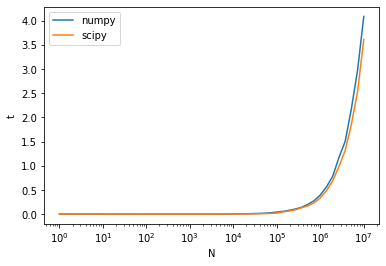

In [522]:
import matplotlib.pyplot as plt

plt.xlabel('N')
plt.ylabel('t')
plt.plot(N, times_new, label='numpy')
plt.plot(N, times_og, label='scipy')
plt.xscale('log')
# plt.yscale('log')
plt.legend()

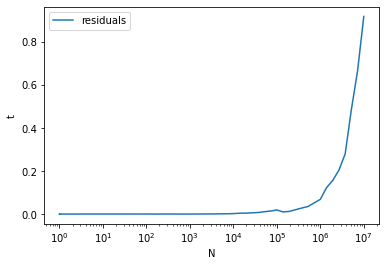

In [119]:
plt.xlabel('N')
plt.ylabel('t')
plt.plot(N, times_new- times_og, label='residuals')

plt.xscale('log')
plt.legend()

In [11]:
def get_indices(xi, grid):
#     indices = []
#     for x, g in zip(xi, grid):
#         i = np.searchsorted(g, x) - 1
#         i[i < 0] = 0
#         i[i > g.size - 2] = g.size - 2
#         indices.append(i)
#     print(np.array(indices).T)#, indices)
    indices_ = np.array([np.searchsorted(g, x) - 1 for x, g in zip(xi, grid)]).T
    return indices_
#     print(indices_)
#     return np.array(indices).T

def reg_grid_interp(xi, grid, values):
    
#     grid = tuple([np.asarray(p) for p in points])
#     values = values
    grid = np.asarray(grid)
    n_coords, ndim = np.shape(xi)
#     print(get_indices(xi.T, grid).shape)
#     indices = np.sum(grid.T < xi.reshape(n_coords,1,ndim), axis=1) - 1 
    indices = get_indices(xi.T, grid)
#     print(indices.shape)
    ndim_axes = np.arange(ndim)
    tmp = grid[ndim_axes, indices]
    norm_distances = ((xi - tmp) / (grid[ndim_axes, indices+1] - tmp)).T
    edge_indices = np.array(list(itertools.product(*[[i, i + 1] for i in indices.T])))
#     edge_indices = np.fromiter(itertools.product(*[[i, i + 1] for i in indices.T]), int)
#         edge_indices = np.array(list(itertools.product(np.hstack([indices.T, indices.T + 1]).reshape(n_coords,2,2))))
#     weights = np.product(np.where(edge_indices == indices.T, 1-norm_distances, norm_distances), axis=1)
    weights = np.where(edge_indices == indices.T, 1-norm_distances, norm_distances).prod(axis=1)

#         print(np.product(np.where(edge_indices == indices.T, 1-norm_distances, norm_distances), axis=1).shape)
#         print(np.where(edge_indices == indices.T, 1-norm_distances, norm_distances).shape)

#         print(weights.shape)
#     edge_indices = tuple(edge_indices.transpose(1,0,2).tolist())
    edge_indices = list(map(tuple, edge_indices.transpose(1,0,2)))
    return (values[edge_indices] * weights).sum(axis=0)

In [12]:
reg_grid_interp(pts, (x, y, z), data)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [541]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [558]:
prof_function = reg_grid_interp

In [559]:
%lprun -f prof_function prof_function(pts, (x, y, z), data)

In [35]:
?np.prod

In [578]:
def find_indices(grid, xi):
        # find relevant edges between which xi are situated
        indices = []
        # compute distance to lower edge in unity units
        norm_distances = []
        # check for out of bounds xi
        out_of_bounds = np.zeros((xi.shape[1]), dtype=bool)
        # iterate through dimensions
        for x, grid in zip(xi, grid):
            i = np.searchsorted(grid, x) - 1
            i[i < 0] = 0
            i[i > grid.size - 2] = grid.size - 2
            indices.append(i)
            norm_distances.append((x - grid[i]) /
                                  (grid[i + 1] - grid[i]))

        return indices, norm_distances

def evaluate_linear(values, indices, norm_distances):
        # slice for broadcasting over trailing dimensions in self.values
        vslice = (slice(None),) + (None,)*(values.ndim - len(indices))
#         print(vslice)
        # find relevant values
        # each i and i+1 represents a edge
        edges = itertools.product(*[[i, i + 1] for i in indices])
#         print(indices)
        res = 0.
        for a, edge_indices in enumerate(edges):
#             print(edge_indices)
            weight = 1.
            for ei, i, yi in zip(edge_indices, indices, norm_distances):
                weight *= np.where(ei == i, 1 - yi, yi)
#             print(weight)
#             print(edge_indices)
#             print(values)
#             print(values[edge_indices])
#             print(weight, edge_indices)
            
            res += np.asarray(values[edge_indices]) * weight[vslice]
        return res
    
def reg_grid_default(pts, points, values):
    grid = tuple([np.asarray(p) for p in points])

    values = np.asarray(values)

    ndim = len(grid)
    xi = _ndim_coords_from_arrays(pts, ndim=ndim)
    xi_shape = xi.shape
    xi = xi.reshape(-1, xi_shape[-1])
#     print(xi.T)
    indices, norm_distances = find_indices(grid, xi.T)
#     print(indices, values.shape)
    
#     result = evaluate_linear(values, indices, norm_distances)
    
    vslice = (slice(None),) + (None,)*(values.ndim - len(indices))
#         print(vslice)
    # find relevant values
    # each i and i+1 represents a edge
    edges = itertools.product(*[[i, i + 1] for i in indices])
#         print(indices)

    res = 0.
    for a, edge_indices in enumerate(edges):
#             print(edge_indices)
        
#         weight = np.product([np.where(ei == i, 1 - yi, yi) for ei, i, yi in zip(edge_indices, indices, norm_distances)], axis=0)
        weight = 1.
        for ei, i, yi in zip(edge_indices, indices, norm_distances):
            weight *= np.where(ei == i, 1 - yi, yi)
#             print(weight)
#             print(edge_indices)
#             print(values)
#             print(values[edge_indices])
#             print(weight, edge_indices)
#         print(weight)
#         print(type(values))
        res += values[edge_indices] * weight[vslice]
    
    return res.reshape(xi_shape[:-1] + values.shape[ndim:])

In [579]:
reg_grid_default(pts, (x, y, z), data)

array([ 78.3704337 , 205.71753648,  76.00304522, ..., 145.74687117,
       114.959507  ,  72.36169083])

In [580]:
prof_function = reg_grid_default

In [581]:
%lprun -f prof_function prof_function(pts, (x, y, z), data)

In [342]:
np.rollaxis(np.indices((2, 3, 3)), 0 , 4)

array([[[[0, 0, 0],
         [0, 0, 1],
         [0, 0, 2]],

        [[0, 1, 0],
         [0, 1, 1],
         [0, 1, 2]],

        [[0, 2, 0],
         [0, 2, 1],
         [0, 2, 2]]],


       [[[1, 0, 0],
         [1, 0, 1],
         [1, 0, 2]],

        [[1, 1, 0],
         [1, 1, 1],
         [1, 1, 2]],

        [[1, 2, 0],
         [1, 2, 1],
         [1, 2, 2]]]])

In [373]:
%timeit np.array(list(itertools.product(range(8), range(13), range(23))))

1.11 ms ± 13.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [372]:
%timeit np.rollaxis(np.asarray(np.meshgrid(range(2), range(3), range(3), indexing='ij')), 0, 4).reshape(-1,3)#.transpose(0,1,2,3)

39.5 µs ± 1.89 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [357]:
np.indices((2, 3, 3)).shape

(3, 2, 3, 3)

In [335]:
np.array(np.meshgrid(range(2), range(3), range(3)))

array([[[[0, 0, 0],
         [1, 1, 1]],

        [[0, 0, 0],
         [1, 1, 1]],

        [[0, 0, 0],
         [1, 1, 1]]],


       [[[0, 0, 0],
         [0, 0, 0]],

        [[1, 1, 1],
         [1, 1, 1]],

        [[2, 2, 2],
         [2, 2, 2]]],


       [[[0, 1, 2],
         [0, 1, 2]],

        [[0, 1, 2],
         [0, 1, 2]],

        [[0, 1, 2],
         [0, 1, 2]]]])

In [397]:
a = np.arange(10)
b = np.arange(5)

In [398]:


i = (a < 1.6).sum()-1

In [399]:
a[[i,i+1]]

array([1, 2])

array([0, 1])

In [400]:
%timeit (a < 1.6).sum()-1

3.17 µs ± 63.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [401]:
%timeit np.searchsorted(a, 1.6) - 1

1.97 µs ± 87.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [402]:
np.searchsorted(a, 1.6) - 1

1

In [577]:
(slice(None),) + (None,)*3

(slice(None, None, None), None, None, None)

In [83]:
import numpy as np
a = np.arange(10,20)

In [84]:
a

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [85]:
xi = np.random.uniform(10,20,6)
xi

array([11.32532305, 13.06436726, 11.32540726, 12.15959255, 16.13241347,
       19.48812371])

In [94]:
idx = np.abs(a-np.floor(xi).reshape(-1,1)).argmin(1)

In [95]:
idx

array([1, 3, 1, 2, 6, 9], dtype=int64)

In [75]:
a[idx].flatten()

array([12, 19, 19, 10, 13, 14])

In [76]:
a.ravel()[np.searchsorted(a.ravel(), xi.ravel()) - 1]

array([12, 19, 19, 10, 13, 14])

In [98]:
def find_indices(arr, x):
    if hasattr(x, "__len__"):
        return [find_indices(arr, xi) for xi in x]
    return np.abs(arr-np.floor(x)).argmin()

In [99]:
find_indices(a, xi[0])

1

In [100]:
find_indices(a, xi)

[1, 3, 1, 2, 6, 9]

In [101]:
np.searchsorted(a, xi) - 1

array([1, 3, 1, 2, 6, 9], dtype=int64)

In [102]:
%timeit find_indices(a, xi[0])

2.92 µs ± 51.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [103]:
%timeit np.searchsorted(a, xi[0]) - 1

2.59 µs ± 105 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [104]:
%timeit find_indices(a, xi)

18.7 µs ± 419 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [105]:
%timeit np.searchsorted(a, xi) - 1

2.5 µs ± 55.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [160]:
indcies = np.arange(6).reshape(-1,2)
edges = list(itertools.product(*indcies))
edges

[(0, 2, 4),
 (0, 2, 5),
 (0, 3, 4),
 (0, 3, 5),
 (1, 2, 4),
 (1, 2, 5),
 (1, 3, 4),
 (1, 3, 5)]

In [167]:
for i in indcies[0]:
    for j in indcies[1]:
        for k in indcies[2]:
            print(i, j, k)

0 2 4
0 2 5
0 3 4
0 3 5
1 2 4
1 2 5
1 3 4
1 3 5
